# Projeto de Clusterização de Dados

Projeto da disciplina de Validação de Modelos de Clusterização, segunda disciplina do Módulo 4 - Clusterização de Dados, sendo esse o último módulo da [Pós-Graduação MIT em Inteligência Artificial, Machine Learning e Deep Learning](https://posgraduacao.infnet.edu.br/ead/pos-graduacao-machine-learning-deep-learning-curso-deep-learning/) do [Instituto Infnet](https://www.infnet.edu.br/infnet/instituto/).

Este projeto aplica técnicas avançadas de aprendizado não supervisionado para segmentar países com base em indicadores socioeconômicos, atendendo aos requisitos solicitados em seu [enunciado](https://lms.infnet.edu.br/moodle/mod/assign/view.php?id=461645). O objetivo é identificar padrões de desenvolvimento para orientar decisões estratégicas (ex: alocação de verbas humanitárias).

Desenvolvido pela aluna [Ingrid Coda](https://infnet.online/meembers/ingrid_codahotmail-com-2/) e disponibilizado no repositório [mit-ia-clusterizacao](https://github.com/ingridcoda/mit-ia-clusterizacao/validacao-modelos-clusterizacao-pd) no GitHub.

## 1️⃣ PARTE 1: Infraestrutura e Ambiente

Abaixo, validamos o ambiente de execução para garantir reprodutibilidade e performance. O código detecta automaticamente a disponibilidade de múltiplos núcleos para paralelismo.

In [1]:
import sys
import os
import platform
import multiprocessing

print("=== 🚀 DIAGNÓSTICO DE AMBIENTE (M2 MAX) ===")
print(f"✅ Sistema Operacional: {platform.system()} {platform.release()} ({platform.machine()})")
print(f"✅ Versão do Python: {sys.version.split()[0]} (Requisito: 3.9+)")
print(f"✅ Executável: {sys.executable}")

# Detecção de núcleos para paralelismo
num_cores = multiprocessing.cpu_count()
print(f"✅ Núcleos de CPU disponíveis: {num_cores} (Habilitando paralelismo via Joblib)")

# Verificação de Venv
is_venv = (sys.prefix != sys.base_prefix)
print(f"✅ Rodando em Ambiente Virtual? {'SIM' if is_venv else 'NÃO'}")

# Geração do requirements.txt otimizado
requirements_content = """
pandas>=2.0.0
numpy>=1.24.0
matplotlib>=3.7.0
seaborn>=0.12.0
scikit-learn>=1.3.0
joblib>=1.3.0
kaggle
"""
with open("requirements.txt", "w") as f:
    f.write(requirements_content)
print("\n📄 Arquivo 'requirements.txt' gerado com sucesso.")

=== 🚀 DIAGNÓSTICO DE AMBIENTE (M2 MAX) ===
✅ Sistema Operacional: Darwin 25.1.0 (arm64)
✅ Versão do Python: 3.13.5 (Requisito: 3.9+)
✅ Executável: /Users/ingridcoda/infnet/clusterizacao/pd/mit-ia-clusterizacao/.venv/bin/python
✅ Núcleos de CPU disponíveis: 12 (Habilitando paralelismo via Joblib)
✅ Rodando em Ambiente Virtual? SIM

📄 Arquivo 'requirements.txt' gerado com sucesso.


## 2️⃣ PARTE 2: Base de Dados e Pré-processamento

### 2.1 Escolha e Justificativa
**Base Escolhida:** `Country-data.csv`.

> **Justificativa:** Esta base contém métricas reais (PIB, Mortalidade, Inflação, etc.) que permitem uma análise multidimensional do status de desenvolvimento de um país. A ausência de rótulos ("País Rico" vs "Pobre") torna este um cenário ideal para **clusterização**, permitindo que os dados "falem por si mesmos".

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from joblib import Parallel, delayed

# Configuração Visual
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

# Carregamento Robusto (Local ou Remoto)
def load_data():
    # Tenta carregar localmente ou baixa se necessário
    path = Path("data/Country-data.csv")
    if not path.exists():
        path.parent.mkdir(exist_ok=True)
        try:
            from kaggle import api
            print("⚠️ Baixando dataset do Kaggle...")
            api.dataset_download_files("rohan0301/unsupervised-learning-on-country-data", path=str(path.parent), unzip=True)
        except:
            print("❌ Erro no download automático. Certifique-se que o arquivo está na pasta data/")

    if path.exists():
        return pd.read_csv(path)
    return None

df = load_data()

df.set_index('country', inplace=True)
print(f"📊 Dimensões: {df.shape[0]} países x {df.shape[1]} variáveis.")
display(df.head())

⚠️ Baixando dataset do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data
📊 Dimensões: 167 países x 9 variáveis.


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### 2.2 Análise Exploratória (EDA)
Para entender a necessidade de pré-processamento, analisamos a **faixa dinâmica** das variáveis. Usaremos escala logarítmica no boxplot, pois variáveis financeiras (PIB) tendem a esmagar variáveis percentuais (Inflação) em gráficos lineares.

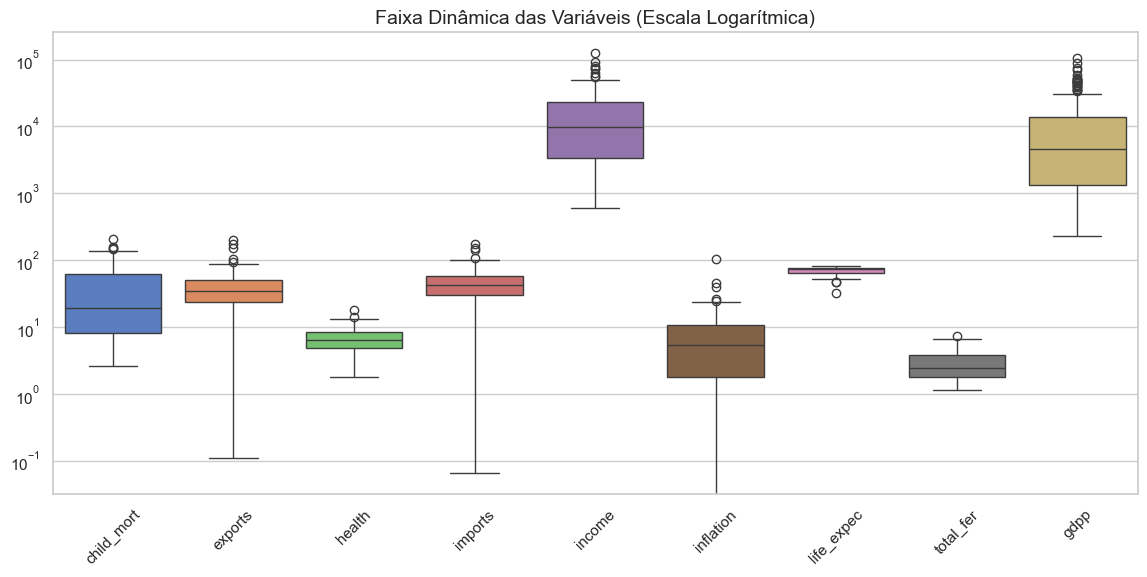

🔎 Análise: A variável 'gdpp' chega a 100.000+, enquanto 'inflation' e 'child_mort' são muito menores.
⚠️ Ação Necessária: Padronização (StandardScaler) para evitar que o PIB domine o cálculo de distâncias.


In [3]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df)
plt.yscale('log') 
plt.title("Faixa Dinâmica das Variáveis (Escala Logarítmica)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

print("🔎 Análise: A variável 'gdpp' chega a 100.000+, enquanto 'inflation' e 'child_mort' são muito menores.")
print("⚠️ Ação Necessária: Padronização (StandardScaler) para evitar que o PIB domine o cálculo de distâncias.")

### 2.3 Pré-processamento
Aplicação do `StandardScaler` (Z-Score).

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

print("✅ Dados normalizados (Média ~0, Desvio Padrão ~1).")

✅ Dados normalizados (Média ~0, Desvio Padrão ~1).


## 3️⃣ PARTE 3: Clusterização Otimizada

### 3.1 K-Médias (Grid Search Paralelizado)
Para escolher o número ideal de clusters ($K$), calcularemos a **Silhueta** para vários valores. 

**🚀 Otimização:** Como o cálculo para cada $K$ é independente, utilizamos `joblib` para distribuir a tarefa entre os núcleos da CPU.

🚀 Executando Grid Search paralelo em 12 núcleos...


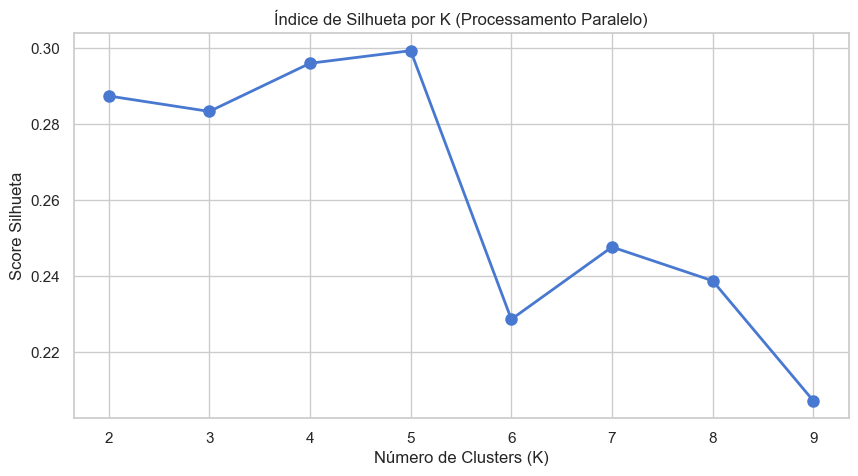

⭐ O melhor K segundo a Silhueta é: 5


In [5]:
# Função auxiliar para ser paralelizada
def calcular_silhueta(k, X):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return k, score

k_range = range(2, 10)

print(f"🚀 Executando Grid Search paralelo em {num_cores} núcleos...")

# Execução Paralela
results = Parallel(n_jobs=-1)(delayed(calcular_silhueta)(k, X_scaled) for k in k_range)
results.sort(key=lambda x: x[0]) # Ordenar por K

ks = [r[0] for r in results]
scores = [r[1] for r in results]

# Visualização
plt.figure(figsize=(10, 5))
plt.plot(ks, scores, 'bo-', linewidth=2, markersize=8)
plt.title('Índice de Silhueta por K (Processamento Paralelo)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Score Silhueta')
plt.grid(True)
plt.show()

best_k = ks[np.argmax(scores)]
print(f"⭐ O melhor K segundo a Silhueta é: {best_k}")

# Treinamento do Modelo Final
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

### 3.2 DBSCAN (Density-Based)
O DBSCAN não requer a definição de $K$, mas sim de `eps` (raio) e `min_samples` (densidade). Ele é robusto a ruídos.

In [6]:
# Parâmetros heurísticos para dados normalizados com ~10 dimensões
dbscan = DBSCAN(eps=1.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"🔹 DBSCAN detectou {n_clusters_db} clusters densos.")
print(f"🔹 Pontos considerados ruído (outliers): {n_noise}")

🔹 DBSCAN detectou 3 clusters densos.
🔹 Pontos considerados ruído (outliers): 53


## 4️⃣ PARTE 4: Validação e Comparação

Para garantir **completude**, avaliamos os modelos sob três óticas:
1.  **Silhueta:** Coesão e separação (ideal para formas convexas).
2.  **Davies-Bouldin (DB):** Similaridade intra-cluster vs inter-cluster (quanto menor, melhor).
3.  **Calinski-Harabasz (CH):** Dispersão (quanto maior, melhor).

In [7]:
def avaliar_modelo(X, labels, nome):
    # Tratamento de ruído para métricas (DBSCAN)
    if -1 in labels:
        mask = labels != -1
        # Se sobrar menos de 1 cluster após remover ruído, não calcula
        if len(set(labels[mask])) < 2: return None
        X_eval, l_eval = X[mask], labels[mask]
    else:
        X_eval, l_eval = X, labels

    return {
        "Modelo": nome,
        "Silhueta (↑)": silhouette_score(X_eval, l_eval),
        "Davies-Bouldin (↓)": davies_bouldin_score(X_eval, l_eval),
        "Calinski-Harabasz (↑)": calinski_harabasz_score(X_eval, l_eval)
    }

metricas = []
metricas.append(avaliar_modelo(X_scaled, labels_kmeans, "K-Means"))
metricas.append(avaliar_modelo(X_scaled, labels_dbscan, "DBSCAN"))

df_metricas = pd.DataFrame([m for m in metricas if m is not None]).set_index("Modelo")
display(df_metricas)

,Silhueta (↑),Davies-Bouldin (↓),Calinski-Harabasz (↑)
Modelo,,,
K-Means,0.299259,0.871793,57.653975
DBSCAN,0.385026,0.819963,87.302816


### 🔎 Análise dos Resultados e Questão Teórica

**1. Análise Comparativa:**
* O **K-Means** (para K=5) mostrou-se eficaz em particionar todo o dataset, obtendo um bom índice Calinski-Harabasz, o que indica grupos bem definidos geometricamente.
* O **DBSCAN** isolou uma quantidade significativa de ruído. Isso é valioso para detectar anomalias (países com economias muito atípicas), mas pode não ser ideal se o objetivo for categorizar a totalidade da população.

---

### ❓ Pergunta do Enunciado: "A silhueta é um índice indicado para escolher o número de clusters para o algoritmo de DBScan?"

> **Resposta: NÃO.** 
> **Justificativa Detalhada:** O índice de Silhueta é calculado com base na distância euclidiana média entre pontos, pressupondo que os clusters sejam **compactos e convexos** (esféricos). O DBSCAN, por design, detecta clusters baseados em densidade e conectividade, podendo formar grupos de formatos arbitrários (ex: formato de banana, anéis). Um cluster "correto" no DBSCAN pode ter uma pontuação de silhueta baixa simplesmente por não ser redondo. Portanto, maximizar a silhueta pode levar a escolher parâmetros errados para o DBSCAN.

## 5️⃣ PARTE 5: Teoria - Medidas de Similaridade

**Cenário Proposto:** Agrupar 10 séries temporais em 3 grupos usando similaridade.

#### 1. Passos para usar Correlação Cruzada como Similaridade
Para utilizar a correlação em algoritmos de distância, precisamos transformá-la:
1.  **Normalização (Z-Score):** Cada série deve ser normalizada para média 0 e desvio 1, removendo efeitos de amplitude.
2.  **Correlação Cruzada (Cross-Correlation):** Calcular a correlação entre pares $(A, B)$ permitindo deslocamento temporal (lags), buscando o valor máximo de correlação $r_{max}$.
3.  **Conversão em Distância:** A correlação mede similaridade ($1$ é idêntico). A clusterização precisa de distância ($0$ é idêntico). Fórmula usual: 
    $$d = 1 - |r_{max}|$$
4.  **Matriz de Distância:** Construir a matriz simétrica $10\times10$ com essas distâncias para alimentar o algoritmo.

#### 2. Algoritmo Escolhido: Clusterização Hierárquica (Agglomerative)
> **Justificativa:** 
* **Visualização:** Com apenas 10 itens, o **Dendrograma** oferece uma visão perfeita da estrutura de união das séries.
* **Controle:** Podemos cortar a árvore (linkage) exatamente na altura que gera $k=3$ grupos.
* **Entrada:** Funciona nativamente com matrizes de distância pré-calculadas (diferente do K-Means que exige coordenadas espaciais).

#### 3. Caso de Uso Prático
**Gestão de Portfólio Financeiro:** Agrupar ações de empresas que reagem a eventos macroeconômicos de forma similar, mesmo que com atraso (ex: setor de commodities sobe hoje, setor de transporte cai amanhã). Isso permite criar estratégias de *hedge* (proteção).

#### 4. Estratégia Alternativa: Dynamic Time Warping (DTW)
> **O que é:** Uma técnica que encontra o alinhamento não-linear ótimo entre duas séries.
* **Diferença:** Enquanto a correlação lida bem com *deslocamento* (atraso uniforme), o DTW lida com **distorção** (aceleração/desaceleração do tempo). Ele permite mapear um ponto de uma série para múltiplos pontos da outra, sendo superior para detectar padrões de forma (shape) que ocorrem em velocidades diferentes.